In [3]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread

### Heat PINN

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation

In [5]:
def visualize_points(x_test, y_test, u_test, norm, title="PINN"):
    # Create a directory to save the images
    save_path="images"
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axis
    plt.scatter(x_test, y_test, c=u_test, marker='o', cmap='viridis', norm=norm)
    plt.title(title)
    plt.colorbar(label='Temperature')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')

    # Save the plot to the images directory
    plt.savefig(os.path.join(save_path, f'{title}.png'))

    # Show the plot
    plt.show()

In [7]:
def set_boundary_conditions(edge_temps, square_size, num_points_per_edge):
    x_boundary_top = np.linspace(0, square_size, num_points_per_edge)
    y_boundary_top = np.ones_like(x_boundary_top) * square_size

    x_boundary_right = np.ones(num_points_per_edge) * square_size
    y_internal_right = np.linspace(0, square_size, num_points_per_edge)

    x_boundary_bottom = np.linspace(square_size, 0, num_points_per_edge)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros(num_points_per_edge)
    y_boundary_left = np.linspace(square_size, 0, num_points_per_edge)

    x_boundary = np.concatenate([x_boundary_top, x_boundary_right, x_boundary_bottom, x_boundary_left])
    y_boundary = np.concatenate([y_boundary_top, y_internal_right, y_boundary_bottom, y_boundary_left])

    u_boundary = np.zeros_like(x_boundary)

    u_boundary[:num_points_per_edge] = edge_temps[0]  # Top edge
    u_boundary[num_points_per_edge:2*num_points_per_edge] = edge_temps[1]  # Right edge
    u_boundary[2*num_points_per_edge:3*num_points_per_edge] = edge_temps[2]  # Bottom edge
    u_boundary[3*num_points_per_edge:] = edge_temps[3]  # Left edge

    class BoundaryConditions:
        def __init__(self, x, y, u):
            self.x = x
            self.y = y
            self.u = u

    boundary_conditions = BoundaryConditions(x_boundary, y_boundary, u_boundary)

    return boundary_conditions

In [8]:
def set_equation(square_size, num_points, random=False):
    if random:
        x_equation = np.random.uniform(0, square_size, num_points)
        y_equation = np.random.uniform(0, square_size, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_equation = x_grid.flatten()
        y_equation = y_grid.flatten()

    class Equation:
        def __init__(self, x, y):
            self.x = x
            self.y = y

    equation = Equation(x_equation, y_equation)

    return equation

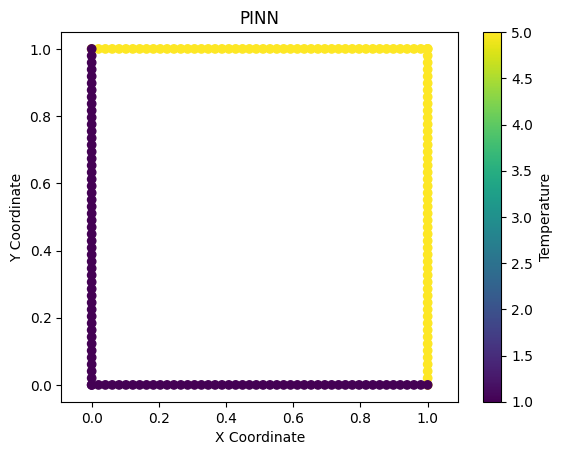

In [11]:
# Set temperatures at the edges [top, right, bottom, left]
edge_temperatures = [5, 5, 1, 1]

# Size of calculation area
square_size = 1.0

# Number of points per edge
num_points_per_edge = 50

# Generate boundary conditions
boundary_conditions = set_boundary_conditions(edge_temperatures, 
                                              square_size, 
                                              num_points_per_edge)

# Number of points in equation
num_points_equation = 100

# Generate equation
equation = set_equation(square_size, num_points_equation, random=False)

temperature_min = np.min(boundary_conditions.u)
temperature_max = np.max(boundary_conditions.u)
norm = Normalize(vmin=temperature_min, vmax=temperature_max)

visualize_points(boundary_conditions.x, boundary_conditions.y, boundary_conditions.u, norm)

In [20]:
class PINN():
    def __init__(self, boundary_conditions, equation):
        # Set data        
        self.x_boundary = torch.tensor(boundary_conditions.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.y_boundary = torch.tensor(boundary_conditions.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.u_boundary = torch.tensor(boundary_conditions.u[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        
        self.x_equation = torch.tensor(equation.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)
        self.y_equation = torch.tensor(equation.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)

        # Coefficient of termal conductivity
        self.alpha = 0.1

        # Null vector is needed in equation loss
        self.null = torch.zeros((self.x_equation.shape[0], 1))

        # Initialize network:
        self.network()

        # Optimizer
        self.optimizer = torch.optim.LBFGS(self.net.parameters(), 
                                           lr=1, 
                                           max_iter=500, 
                                           max_eval=50000,
                                           history_size=50, 
                                           tolerance_grad=1e-05, 
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # Loss function
        self.mse = nn.MSELoss()

        # Loss
        self.loss = 0

        # Iteration number
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def function(self, x, y, is_equation=False):
        u_pred = self.net(torch.hstack((x, y)))

        if is_equation:
            dudx = torch.autograd.grad(u_pred, x, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udx2 = torch.autograd.grad(dudx, x, 
                                         grad_outputs=torch.ones_like(dudx), 
                                         create_graph=True)[0]
            dudy = torch.autograd.grad(u_pred, y, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udy2 = torch.autograd.grad(dudy, y, 
                                         grad_outputs=torch.ones_like(dudy), 
                                         create_graph=True)[0]
            return u_pred, d2udx2, d2udy2

        return u_pred

    def closure(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # Boundary loss
        u_prediction = self.function(self.x_boundary, self.y_boundary)
        boundary_loss = self.mse(u_prediction, self.u_boundary)

        # Equation loss
        _, d2udx2, d2udy2 = self.function(self.x_equation, self.y_equation, is_equation=True)
        heat_eq_prediction = d2udx2 + d2udy2
        equation_loss = self.mse(heat_eq_prediction, self.null)

        self.loss = boundary_loss + equation_loss

        # Derivative with respect to weights
        self.loss.backward()

        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.loss))

        return self.loss

    def train(self):
        # Training loop
        self.net.train()
        self.optimizer.step(self.closure)

In [21]:
# Create model
pinn = PINN(boundary_conditions, equation)

# Train model
pinn.train()

# Save model
torch.save(pinn.net.state_dict(), 'model.pt')

Iteration: 1, Loss: 13.120008
Iteration: 2, Loss: 12.525862
Iteration: 3, Loss: 7.939921
Iteration: 4, Loss: 35.338291
Iteration: 5, Loss: 4.075068


c:\Users\rvetl\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10000, 1], strides() = [1, 0]
param.sizes() = [10000, 1], strides() = [1, 0] (Triggered internally at ..\torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 6, Loss: 4.045320
Iteration: 7, Loss: 3.996656
Iteration: 8, Loss: 3.995167
Iteration: 9, Loss: 3.988770
Iteration: 10, Loss: 3.972147
Iteration: 11, Loss: 3.857326
Iteration: 12, Loss: 13.228041
Iteration: 13, Loss: 3.687719
Iteration: 14, Loss: 3.621533
Iteration: 15, Loss: 3.560883
Iteration: 16, Loss: 3.555105
Iteration: 17, Loss: 3.562795
Iteration: 18, Loss: 3.549814
Iteration: 19, Loss: 9.333635
Iteration: 20, Loss: 3.546916
Iteration: 21, Loss: 3.441732
Iteration: 22, Loss: 3.245089
Iteration: 23, Loss: 3.160543
Iteration: 24, Loss: 3.153925
Iteration: 25, Loss: 3.012253
Iteration: 26, Loss: 2.947964
Iteration: 27, Loss: 2.736181
Iteration: 28, Loss: 78.863518
Iteration: 29, Loss: 2.689623
Iteration: 30, Loss: 2.436006
Iteration: 31, Loss: 2.120384
Iteration: 32, Loss: 2.122027
Iteration: 33, Loss: 2.062376
Iteration: 34, Loss: 2.012167
Iteration: 35, Loss: 1.904631
Iteration: 36, Loss: 2.173403
Iteration: 37, Loss: 1.866416
Iteration: 38, Loss: 1.833625
Iteration: 3

In [23]:
def set_test(square_size, num_points, random=False):
    if random:
        x_test = np.random.uniform(0, square_size, num_points)
        y_test = np.random.uniform(0, square_size, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_test = x_grid.flatten()
        y_test = y_grid.flatten()   

    class Test:
        def __init__(self, x, y):
            self.x = x
            self.y = y

    test = Test(x_test, y_test)

    return test

In [24]:
pinn = PINN(boundary_conditions, equation)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

test = set_test(1, 100)

x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(test.y[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u = pinn.function(x_test, y_test)

torch.Size([10000, 1])


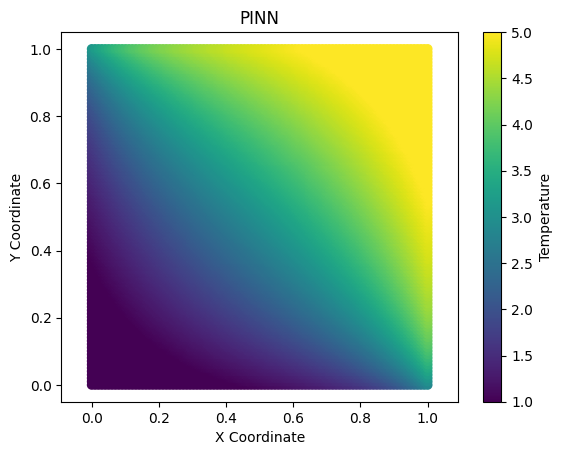

In [25]:
print(u.shape)

visualize_points(test.x, test.y, u.to('cpu').detach().numpy(), norm)

### FDM solver

In [26]:
def set_boundary_conditions(edge_temperatures, u):    
    u[0, :] = edge_temperatures[0]  # Top
    u[:, -1] = edge_temperatures[1]  # Right
    u[-1, :] = edge_temperatures[2]  # Bottom
    u[:, 0] = edge_temperatures[3]  # Left

    return u

In [27]:
# Coefficient of termal conductivity
alpha = 0.1

# Size of calculation area
square_size = 1.0

# Number of points per edge
num_points = 100

dt = 0.1 # time step
T = 0.1 # final time

# Set temperatures at the edges [top, right, bottom, left] and initial temperature
edge_temperatures = [5, 5, 1, 1]
initial_temperature = 2

# Size of calculation area
square_size = 1.0

# Computes cell length
dx = square_size/num_points
dy = square_size/num_points

# Courant number
CFL = 0.1
dt = CFL * pow(dx, 2) / alpha

u = np.zeros((num_points,num_points))
print("Size of calculation area", u.shape)

u = set_initial_conditions(initial_temperature, u)
u = set_boundary_conditions(edge_temperatures, u)

# Generate 2D mesh
X = np.linspace(0, square_size, num_points, endpoint=True)
Y = np.linspace(0, square_size, num_points, endpoint=True)
X, Y = np.meshgrid(X, Y)

# Main spatial loop for stationary heat equation
for iter in range(100):
    u_new = u.copy()  # Create a copy for simultaneous update

    for i in range(1, num_points - 1):
        for j in range(1, num_points - 1):
            a = (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / dx**2  # d2dx2
            b = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy**2  # d2dy2
            u_new[i, j] = alpha * (a + b)  # Stationary heat equation

    u = u_new  # Update temperature field

Size of calculation area (100, 100)


C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:46: RuntimeWarning: overflow encountered in scalar add
  u_new[i, j] = alpha * (a + b)  # Stationary heat equation
C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:44: RuntimeWarning: overflow encountered in scalar divide
  a = (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / dx**2  # d2dx2
C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:45: RuntimeWarning: overflow encountered in scalar divide
  b = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy**2  # d2dy2
C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:45: RuntimeWarning: invalid value encountered in scalar subtract
  b = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy**2  # d2dy2
C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:45: RuntimeWarning: invalid value encountered in scalar add
  b = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy**2  # d2dy2
C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\592165741.py:46: RuntimeW

In [31]:
def visualize_temperature(u, time_index, norm, title="FDM"):
    # Create a directory to save the images
    save_path="images"

    # Create a figure and axis
    os.makedirs(save_path, exist_ok=True)

    plt.imshow(u[:, :], cmap='viridis', origin='lower',
               extent=[0, 1, 0, 1], norm=norm)
    
    plt.colorbar(label='Temperature')
    plt.title(f'Temperature Distribution at Time Step {time_index}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Save the plot to the images directory
    plt.savefig(os.path.join(save_path, f'{title}.png'))

    # Show the plot
    plt.show()

In [32]:
temperature_min = np.min(u)
temperature_max = np.max(u)
print(temperature_min, temperature_max)

nan nan


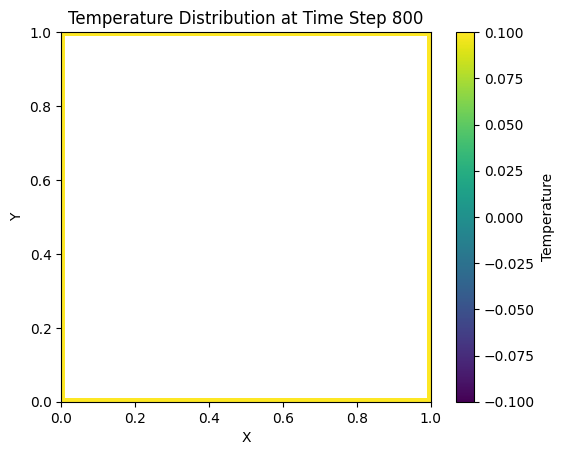

In [33]:
temperature_min = np.min(u)
temperature_max = np.max(u)
norm=Normalize(vmin=temperature_min, vmax=temperature_max)

t_index = 800

visualize_temperature(u, t_index, norm)

### FEM or FVM solver

In [50]:
# TODO: FEM or FVM solver for 2D heat transfer problem implementation

### Compare methods

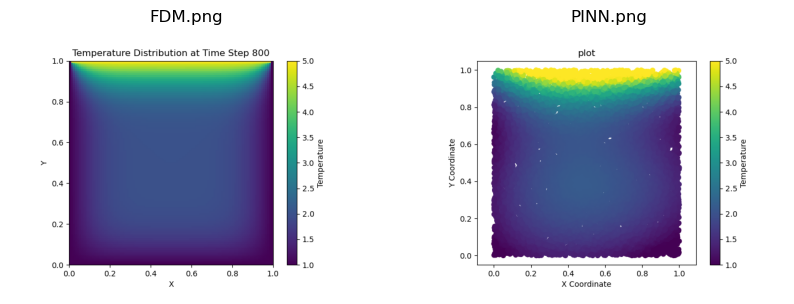

In [144]:
images_folder = "images"
image_files = os.listdir(images_folder)
image_files = [f for f in image_files if f.endswith(".png") and (f.startswith("PINN") or f.startswith("FDM"))]

if len(image_files) == 2:
    image1 = imread(os.path.join(images_folder, image_files[0]))
    image2 = imread(os.path.join(images_folder, image_files[1]))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].set_title(image_files[0])
    axes[0].axis("off")

    axes[1].imshow(image2)
    axes[1].set_title(image_files[1])
    axes[1].axis("off")

    plt.show()

### Analytical solution

C:\Users\rvetl\AppData\Local\Temp\ipykernel_7092\2946747368.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))


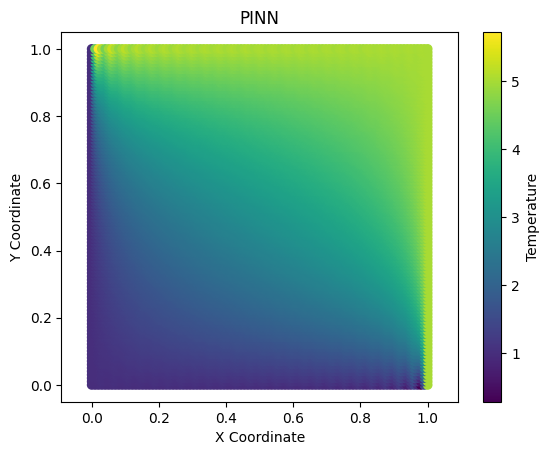

In [11]:
def analytical_solution(x, y):
    l_x = 1.0
    l_y = 1.0
    u_1 = 1.0
    u_2 = 5.0
    lambda_n = [n * np.pi / l_x for n in range(1, 52)]
    return (u_1 + (u_2 - u_1) * (x / l_x)
    + 2.0*(u_2 - u_1) * np.sum(1.0 / (n * np.pi * np.sinh(np.sqrt(lambda_n[n]) * l_y)) * (np.sinh(np.sqrt(lambda_n[n]) * y) + pow(-1, n) * np.sinh(np.sqrt(lambda_n[n]) * (l_y - y))) * np.sin(n * np.pi * x / l_x) for n in range(1, 50)))

# Создание сетки для визуализации
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

x_grid, y_grid = np.meshgrid(x, y)

x_test = x_grid.flatten()
y_test = y_grid.flatten()

u = analytical_solution(x_test, y_test)

temperature_min = np.min(u)
temperature_max = np.max(u)
norm = Normalize(vmin=temperature_min, vmax=temperature_max)

visualize_points(x_test,y_test, u, norm)